## 1. 데이터 로드

In [4]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import shutil
from autogluon.tabular import TabularPredictor

warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [5]:
# 데이터 로드
train = pd.read_csv('C:/Users/subin/github/Little-Sonny/data/train.csv')
test = pd.read_csv('C:/Users/subin/github/Little-Sonny/data/test.csv')
submission = pd.read_csv('C:/Users/subin/github/Little-Sonny/data/sample_submission.csv')

print(f'Train 데이터 크기: {train.shape}')
print(f'Test 데이터 크기: {test.shape}')
print(f'Submission 데이터 크기: {submission.shape}')

Train 데이터 크기: (3019, 66)
Test 데이터 크기: (1626, 65)
Submission 데이터 크기: (1626, 2)


## 2. 데이터 확인

#### 1. 기본 인적 사항 (Basic Profile)

* **ID**: 선수 고유 식별 번호
* **Age**: 나이 (유망주 판단의 결정적 요소)
* **Height / Weight**: 키(cm) 및 몸무게(kg)
* **Position**: 주 포지션
* **PreferredFoot**: 주발 (Left / Right)
* **Attacking / Defensive WorkRate**: 공격 및 수비 참여도 (High/Medium/Low)

#### 2. 6대 핵심 요약 스탯 (Main Totals)

* **PaceTotal / ShootingTotal / PassingTotal**: 속도, 슈팅, 패스 능력 합계
* **DribblingTotal / DefendingTotal / PhysicalityTotal**: 드리블, 수비, 피지컬 능력 합계

#### 3. 세부 기술 스탯 (Technical Skills)

* **공격 기술**: `Crossing`(크로스), `Finishing`(결정력), `HeadingAccuracy`(헤더), `Volleys`(발리슛), `Curve`(커브), `FKAccuracy`(프리킥), `LongShots`(중거리슛), `Penalties`(PK)
* **패스/컨트롤**: `ShortPassing`(짧은패스), `LongPassing`(긴패스), `BallControl`(볼컨트롤), `Vision`(시야)
* **수비 기술**: `Marking`(대인방어), `StandingTackle`(태클), `SlidingTackle`(슬라이딩 태클), `Interceptions`(가로채기)

#### 4. 신체 및 심리 스탯 (Physical & Mental)

* **운동 능력**: `Acceleration`(가속력), `SprintSpeed`(주력), `Agility`(민첩성), `Reactions`(반응속도), `Balance`(밸런스), `ShotPower`(슛파워), `Jumping`(점프력), `Stamina`(체력), `Strength`(힘)
* **심리/태도**: `Aggression`(적극성), `Positioning`(위치선정), `Composure`(침착함)

#### 5. 골키퍼 전용 스탯 (GK Special)

* **GK 스탯 5종**: `GKDiving`, `GKHandling`, `GKKicking`, `GKPositioning`, `GKReflexes`

#### 6. 포지션별 숙련도 레이팅 (Detailed Ratings)

* **공격**: `STRating`, `LW/RW/LF/RF/CF Rating`
* **미드필더**: `CAM/LM/CM/RM/CDM Rating`
* **수비**: `LWB/RWB/LB/RB/CB Rating`
* **골키퍼**: `GKRating`

#### 7. 타겟 변수 (The Goal)

* **Prospect**: **유망주 여부 (0: 일반, 1: 유망주)**

In [6]:
import pandas as pd

# 2. 구분용 컬럼 생성 (나중에 분리하기 위함)
train['is_train'] = True
test['is_train'] = False

# 3. 데이터 합치기 (행 방향으로 연결)
# 테스트 데이터에는 타겟(정답) 컬럼이 없을 수 있으므로, 
# 합치면 테스트 데이터 쪽 타겟 컬럼은 자동으로 NaN(결측치) 처리가 됩니다.
base_data = pd.concat([train, test], axis=0).reset_index(drop=True)

print(f"Base Data Shape: {base_data.shape}")

Base Data Shape: (4645, 67)


In [4]:
base_data.head()

,ID,Age,Height,Weight,Position,PreferredFoot,AttackingWorkRate,DefensiveWorkRate,PaceTotal,ShootingTotal,...,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating,Prospect,is_train
0,TRAIN_0000,21,182,82,CB,Right,Medium,Medium,4.6377,2.1053,...,4.8649,6.1972,6.0000,6.1972,6.4286,6.5278,6.4286,0.875,0.0,True
1,TRAIN_0001,21,160,75,ST,Left,High,Medium,7.3913,7.3684,...,6.4865,5.2113,4.4286,5.2113,5.0000,4.1667,5.0000,1.250,0.0,True
2,TRAIN_0002,18,165,60,RB,Right,Medium,Medium,6.2319,3.2895,...,5.2703,5.7746,5.1429,5.7746,5.8571,5.0000,5.8571,0.750,0.0,True
3,TRAIN_0003,20,190,72,CB,Right,Medium,Medium,4.7826,1.0526,...,2.2973,4.0845,3.7143,4.0845,4.5714,4.5833,4.5714,0.875,0.0,True
4,TRAIN_0004,21,181,77,ST,Right,High,Medium,8.2609,7.3684,...,7.5676,5.2113,4.2857,5.2113,4.7143,3.3333,4.7143,1.125,0.0,True


--- 📊 little sonny 팀의 나이대별 유망주 비율 분석 ---
     Total  Prospects  Prospect_Rate (%)
Age                                     
16      31         18              58.06
17     249        151              60.64
18     626        319              50.96
19    1039        339              32.63
20    1260        206              16.35
21    1440         57               3.96
--------------------------------------------------


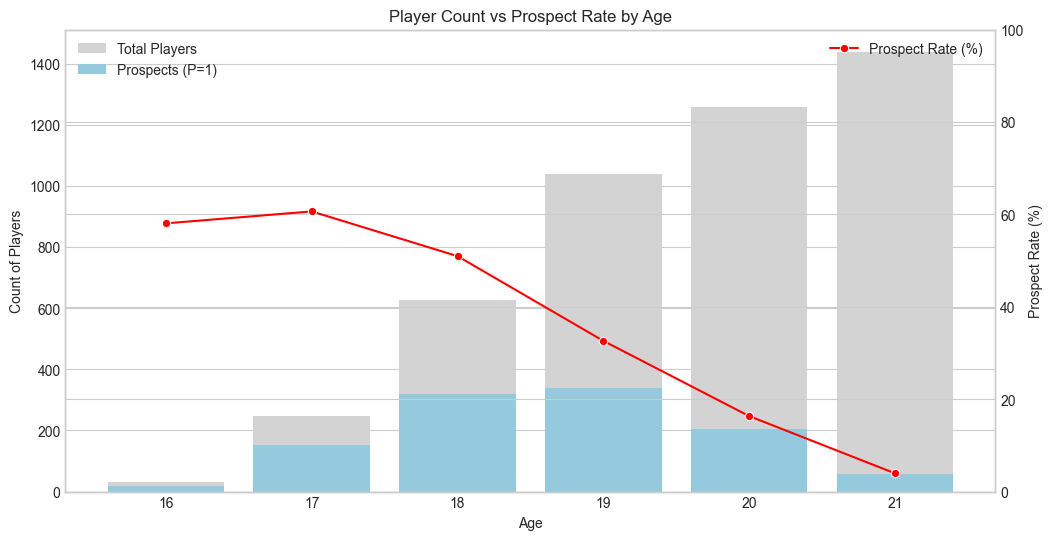

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 나이대별 전체 인원과 유망주 인원 계산
age_total = base_data['Age'].value_counts().sort_index()
age_prospects = base_data[base_data['Prospect'] == 1]['Age'].value_counts().sort_index()

# 2. 데이터프레임으로 합치기
age_analysis = pd.DataFrame({
    'Total': age_total,
    'Prospects': age_prospects
})

# 3. 유망주 비율(%) 계산
age_analysis['Prospect_Rate (%)'] = (age_analysis['Prospects'] / age_analysis['Total'] * 100).round(2)

print("--- 📊 little sonny 팀의 나이대별 유망주 비율 분석 ---")
print(age_analysis)
print("-" * 50)

# 4. 시각화 (복합 그래프: 인원수는 막대, 비율은 선 그래프)
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 전체 인원 vs 유망주 인원
sns.barplot(x=age_analysis.index, y=age_analysis['Total'], color='lightgrey', label='Total Players', ax=ax1)
sns.barplot(x=age_analysis.index, y=age_analysis['Prospects'], color='skyblue', label='Prospects (P=1)', ax=ax1)
ax1.set_ylabel('Count of Players')
ax1.legend(loc='upper left')

# 선 그래프: 유망주 비율 (이중축 사용)
ax2 = ax1.twinx()
sns.lineplot(x=range(len(age_analysis)), y=age_analysis['Prospect_Rate (%)'], color='red', marker='o', label='Prospect Rate (%)', ax=ax2)
ax2.set_ylabel('Prospect Rate (%)')
ax2.set_ylim(0, 100)
ax2.legend(loc='upper right')

plt.title('Player Count vs Prospect Rate by Age')
plt.show()

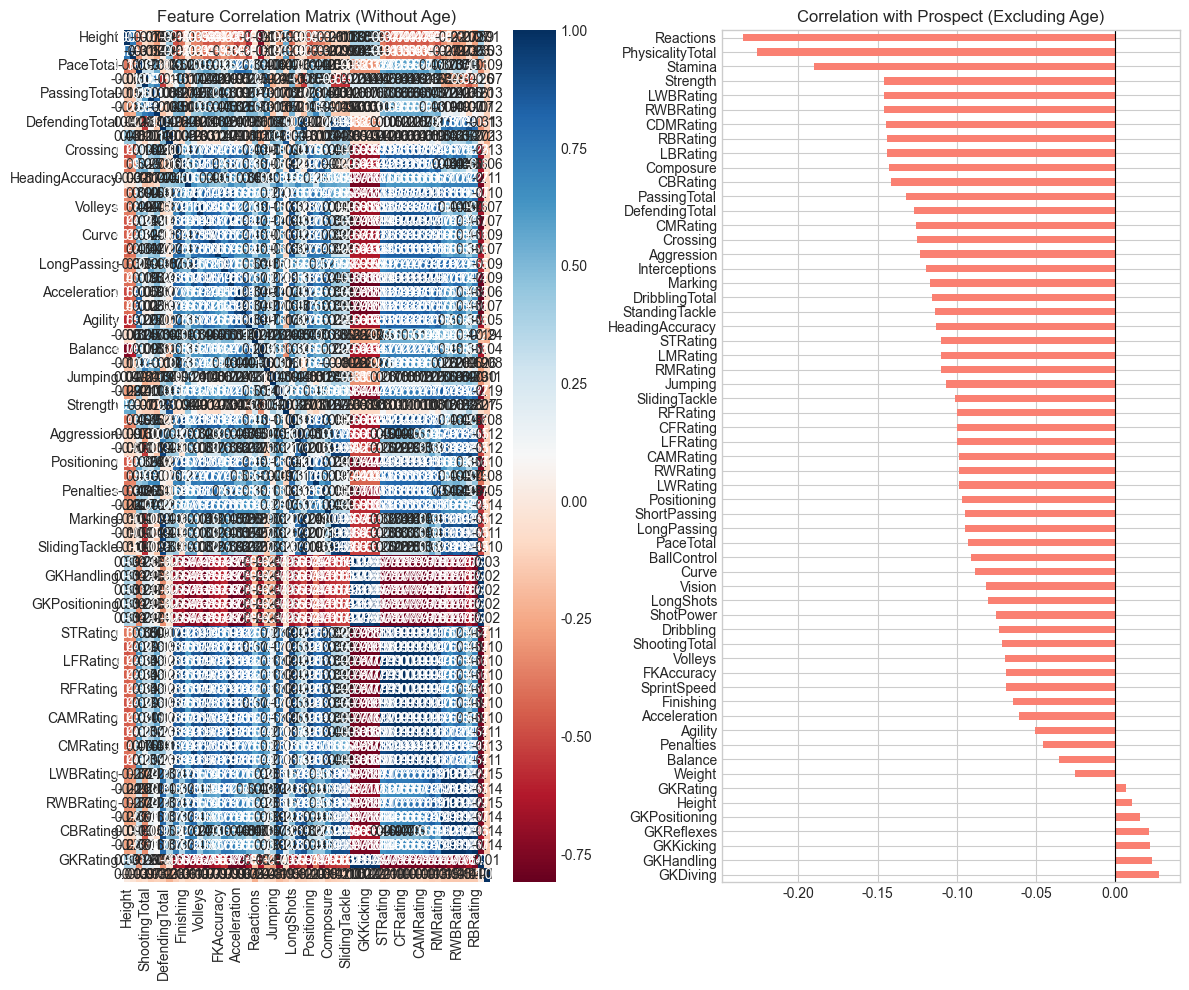

--- 유망주 판단에 영향력이 큰 순서 ---
GKDiving            0.027625
GKHandling          0.022902
GKKicking           0.021931
GKReflexes          0.021446
GKPositioning       0.015245
Height              0.010178
GKRating            0.006496
Weight             -0.025572
Balance            -0.035366
Penalties          -0.045903
Agility            -0.050918
Acceleration       -0.060929
Finishing          -0.064901
SprintSpeed        -0.068807
FKAccuracy         -0.069066
Volleys            -0.069697
ShootingTotal      -0.071425
Dribbling          -0.073731
ShotPower          -0.075408
LongShots          -0.080141
Vision             -0.081667
Curve              -0.088404
BallControl        -0.091026
PaceTotal          -0.093176
LongPassing        -0.094604
ShortPassing       -0.095094
Positioning        -0.096851
LWRating           -0.098644
RWRating           -0.098644
CAMRating          -0.098875
LFRating           -0.100184
CFRating           -0.100184
RFRating           -0.100184
SlidingTackle    

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 수치형 데이터만 선택
numeric_base = base_data.select_dtypes(include=['number'])

# 2. 'Age' 컬럼을 제외한 나머지 변수들 간의 상관계수 계산
# Age가 포함되면 다른 변수의 영향력이 가려질 수 있으므로 제거 후 계산
features_to_analyze = numeric_base.drop(columns=['Age'])
correlations = features_to_analyze.corr()

# 3. 'Prospect'와 다른 변수들 간의 상관계수만 추출하여 정렬
prospect_corr = correlations['Prospect'].drop('Prospect').sort_values(ascending=False)

# 4. 시각화 (Heatmap & Bar chart)
plt.figure(figsize=(12, 10))

# 왼쪽: 전체 히트맵 (변수 간의 관계)
plt.subplot(1, 2, 1)
sns.heatmap(correlations, annot=True, cmap='RdBu', fmt=".2f")
plt.title('Feature Correlation Matrix (Without Age)')

# 오른쪽: 유망주와의 상관계수 순위
plt.subplot(1, 2, 2)
prospect_corr.plot(kind='barh', color='salmon')
plt.title('Correlation with Prospect (Excluding Age)')
plt.axvline(0, color='black', linewidth=0.8) # 0 지점에 선 긋기

plt.tight_layout()
plt.show()

print("--- 유망주 판단에 영향력이 큰 순서 ---")
print(prospect_corr)

## 18세 데이터 선택 이유

전체 비율을 봤을 때 19-21세 데이터는 유망주 기준 매우 적은 비율을 차지하고 있어 중앙값이자 대표적인 값으로 선택

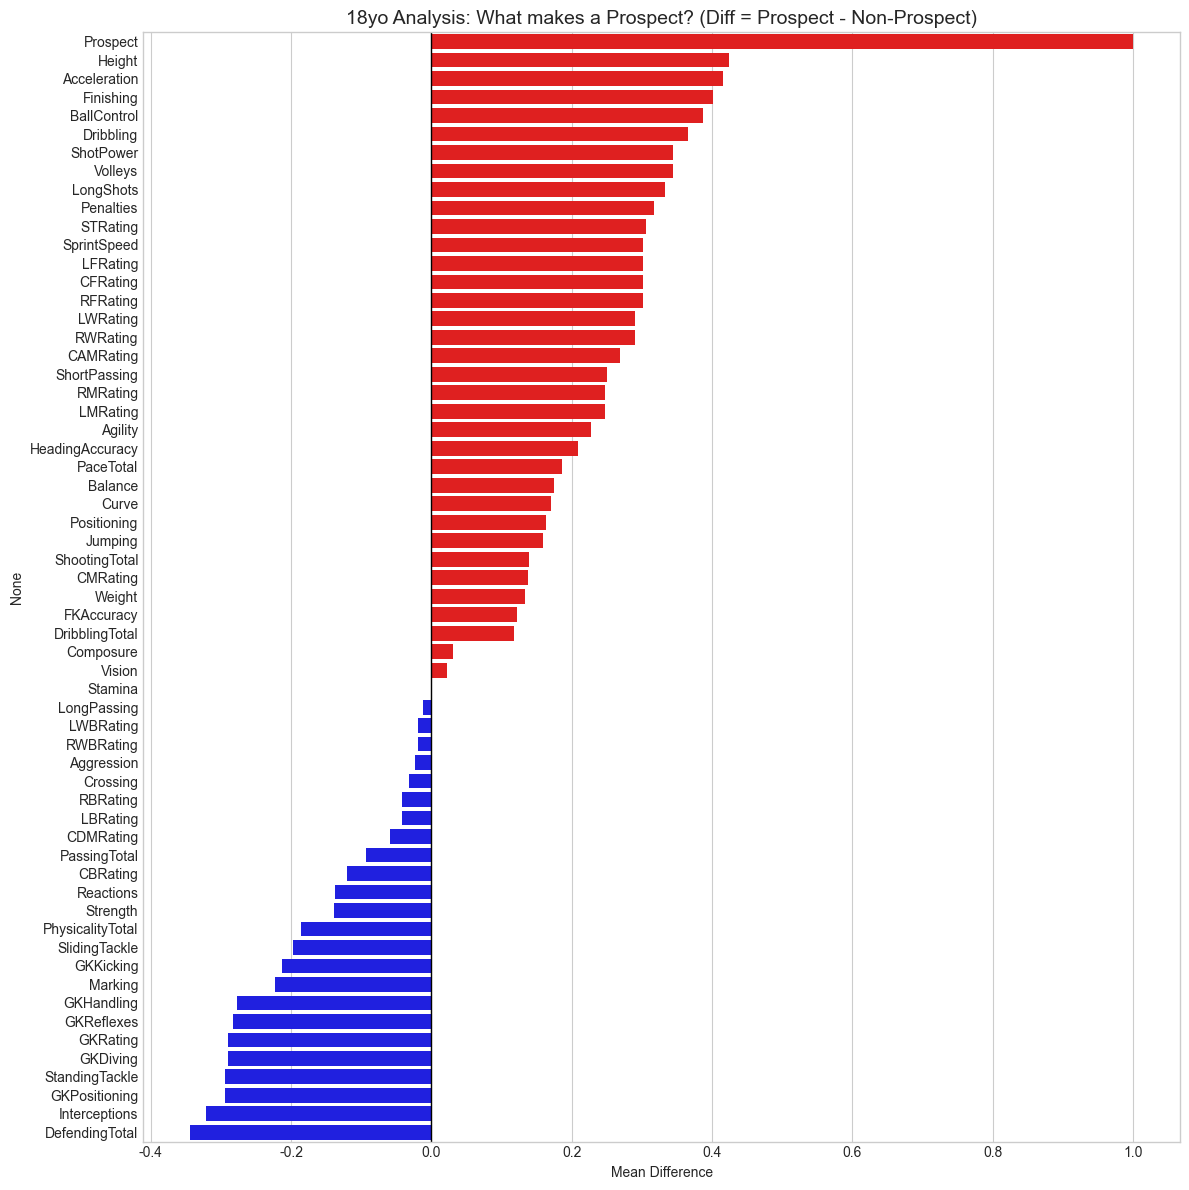

18세 유망주를 가르는 핵심 지표 (차이값이 클수록 중요):
Prospect        1.000000
Height          0.423961
Acceleration    0.416193
Finishing       0.401624
BallControl     0.386529
Dribbling       0.366036
ShotPower       0.345058
Volleys         0.344001
LongShots       0.332396
Penalties       0.317357
Name: Diff, dtype: float64


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 18세 데이터만 추출
df_18 = base_data[base_data['Age'] == 18].copy()

# 2. 수치형 컬럼만 선택 (Age 제외)
numeric_cols = df_18.select_dtypes(include=['number']).columns.tolist()
if 'Age' in numeric_cols: numeric_cols.remove('Age')

# 3. 그룹화 및 평균 계산
# .T를 하면 'Prospect'의 값들이 컬럼 이름이 됩니다.
comparison = df_18.groupby('Prospect')[numeric_cols].mean().T

# [중요] 컬럼 이름이 무엇인지 상관없이 '유망주 - 비유망주'를 계산하도록 보정
# 보통 1(True)이 유망주, 0(False)이 비유망주입니다.
cols = comparison.columns.tolist()
# 만약 1과 0이라면, 1에서 0을 뺍니다.
if 1 in cols and 0 in cols:
    comparison['Diff'] = comparison[1] - comparison[0]
# 만약 True와 False(불리언)라면
elif True in cols and False in cols:
    comparison['Diff'] = comparison[True] - comparison[False]
# 그 외의 경우 (문자열 등) 마지막 컬럼에서 첫 번째 컬럼을 빼는 식으로 유연하게 대응
else:
    comparison['Diff'] = comparison[cols[-1]] - comparison[cols[0]]

comparison = comparison.sort_values(by='Diff', ascending=False)

# 4. 시각화
plt.figure(figsize=(12, 12))
# 값이 양수인 것(유망주가 높은 것)은 빨간색, 음수는 파란색으로 표시
colors = ['red' if x > 0 else 'blue' for x in comparison['Diff']]
sns.barplot(x=comparison['Diff'], y=comparison.index, palette=colors)

plt.title('18yo Analysis: What makes a Prospect? (Diff = Prospect - Non-Prospect)', fontsize=14)
plt.xlabel('Mean Difference')
plt.axvline(0, color='black', lw=1)
plt.tight_layout()
plt.show()

# 수치 데이터 상위 10개 출력
print("18세 유망주를 가르는 핵심 지표 (차이값이 클수록 중요):")
print(comparison['Diff'].head(10))

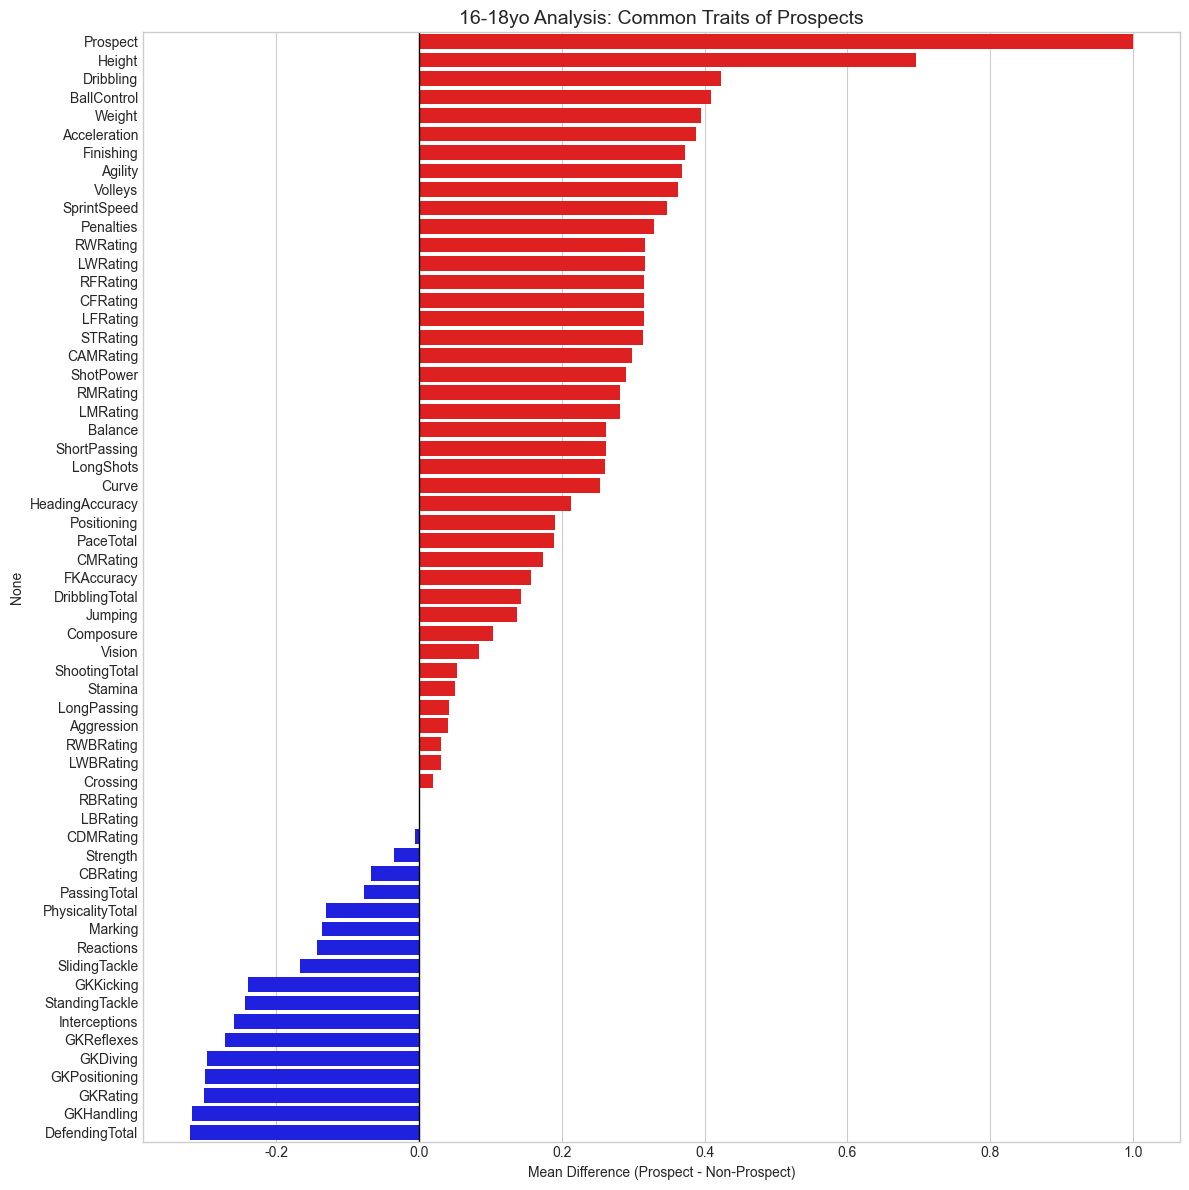

16-18세 통합 유망주 핵심 지표 Top 10:
Prospect        1.000000
Height          0.695961
Dribbling       0.423172
BallControl     0.408628
Weight          0.394140
Acceleration    0.387614
Finishing       0.372793
Agility         0.368021
Volleys         0.362724
SprintSpeed     0.347528
Penalties       0.328653
RWRating        0.315721
LWRating        0.315721
RFRating        0.315470
CFRating        0.315470
Name: Diff, dtype: float64


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 16세~18세 데이터 추출
df_young = base_data[base_data['Age'].isin([16, 17, 18])].copy()

# 2. 수치형 컬럼 선택 (Age 제외)
numeric_cols = df_young.select_dtypes(include=['number']).columns.tolist()
if 'Age' in numeric_cols: numeric_cols.remove('Age')

# 3. 그룹화 및 평균 계산
comparison_young = df_young.groupby('Prospect')[numeric_cols].mean().T

# 컬럼 이름 대응 (1/0 또는 True/False 또는 문자열)
cols = comparison_young.columns.tolist()
if 1 in cols and 0 in cols:
    comparison_young['Diff'] = comparison_young[1] - comparison_young[0]
elif True in cols and False in cols:
    comparison_young['Diff'] = comparison_young[True] - comparison_young[False]
else:
    comparison_young['Diff'] = comparison_young[cols[-1]] - comparison_young[cols[0]]

comparison_young = comparison_young.sort_values(by='Diff', ascending=False)

# 4. 시각화
plt.figure(figsize=(12, 12))
colors = ['red' if x > 0 else 'blue' for x in comparison_young['Diff']]
sns.barplot(x=comparison_young['Diff'], y=comparison_young.index, palette=colors)

plt.title('16-18yo Analysis: Common Traits of Prospects', fontsize=14)
plt.xlabel('Mean Difference (Prospect - Non-Prospect)')
plt.axvline(0, color='black', lw=1)
plt.tight_layout()
plt.show()

print("16-18세 통합 유망주 핵심 지표 Top 10:")
print(comparison_young['Diff'].head(15))

In [9]:
# 전체 데이터에 있는 포지션 종류 확인
position_list = base_data['Position'].unique()
print(position_list)

['CB' 'ST' 'RB' 'LB' 'GK' 'CDM' 'CAM' 'CM' 'RM' 'LM' 'RWB' 'LWB' 'RW' 'CF'
 'LW']


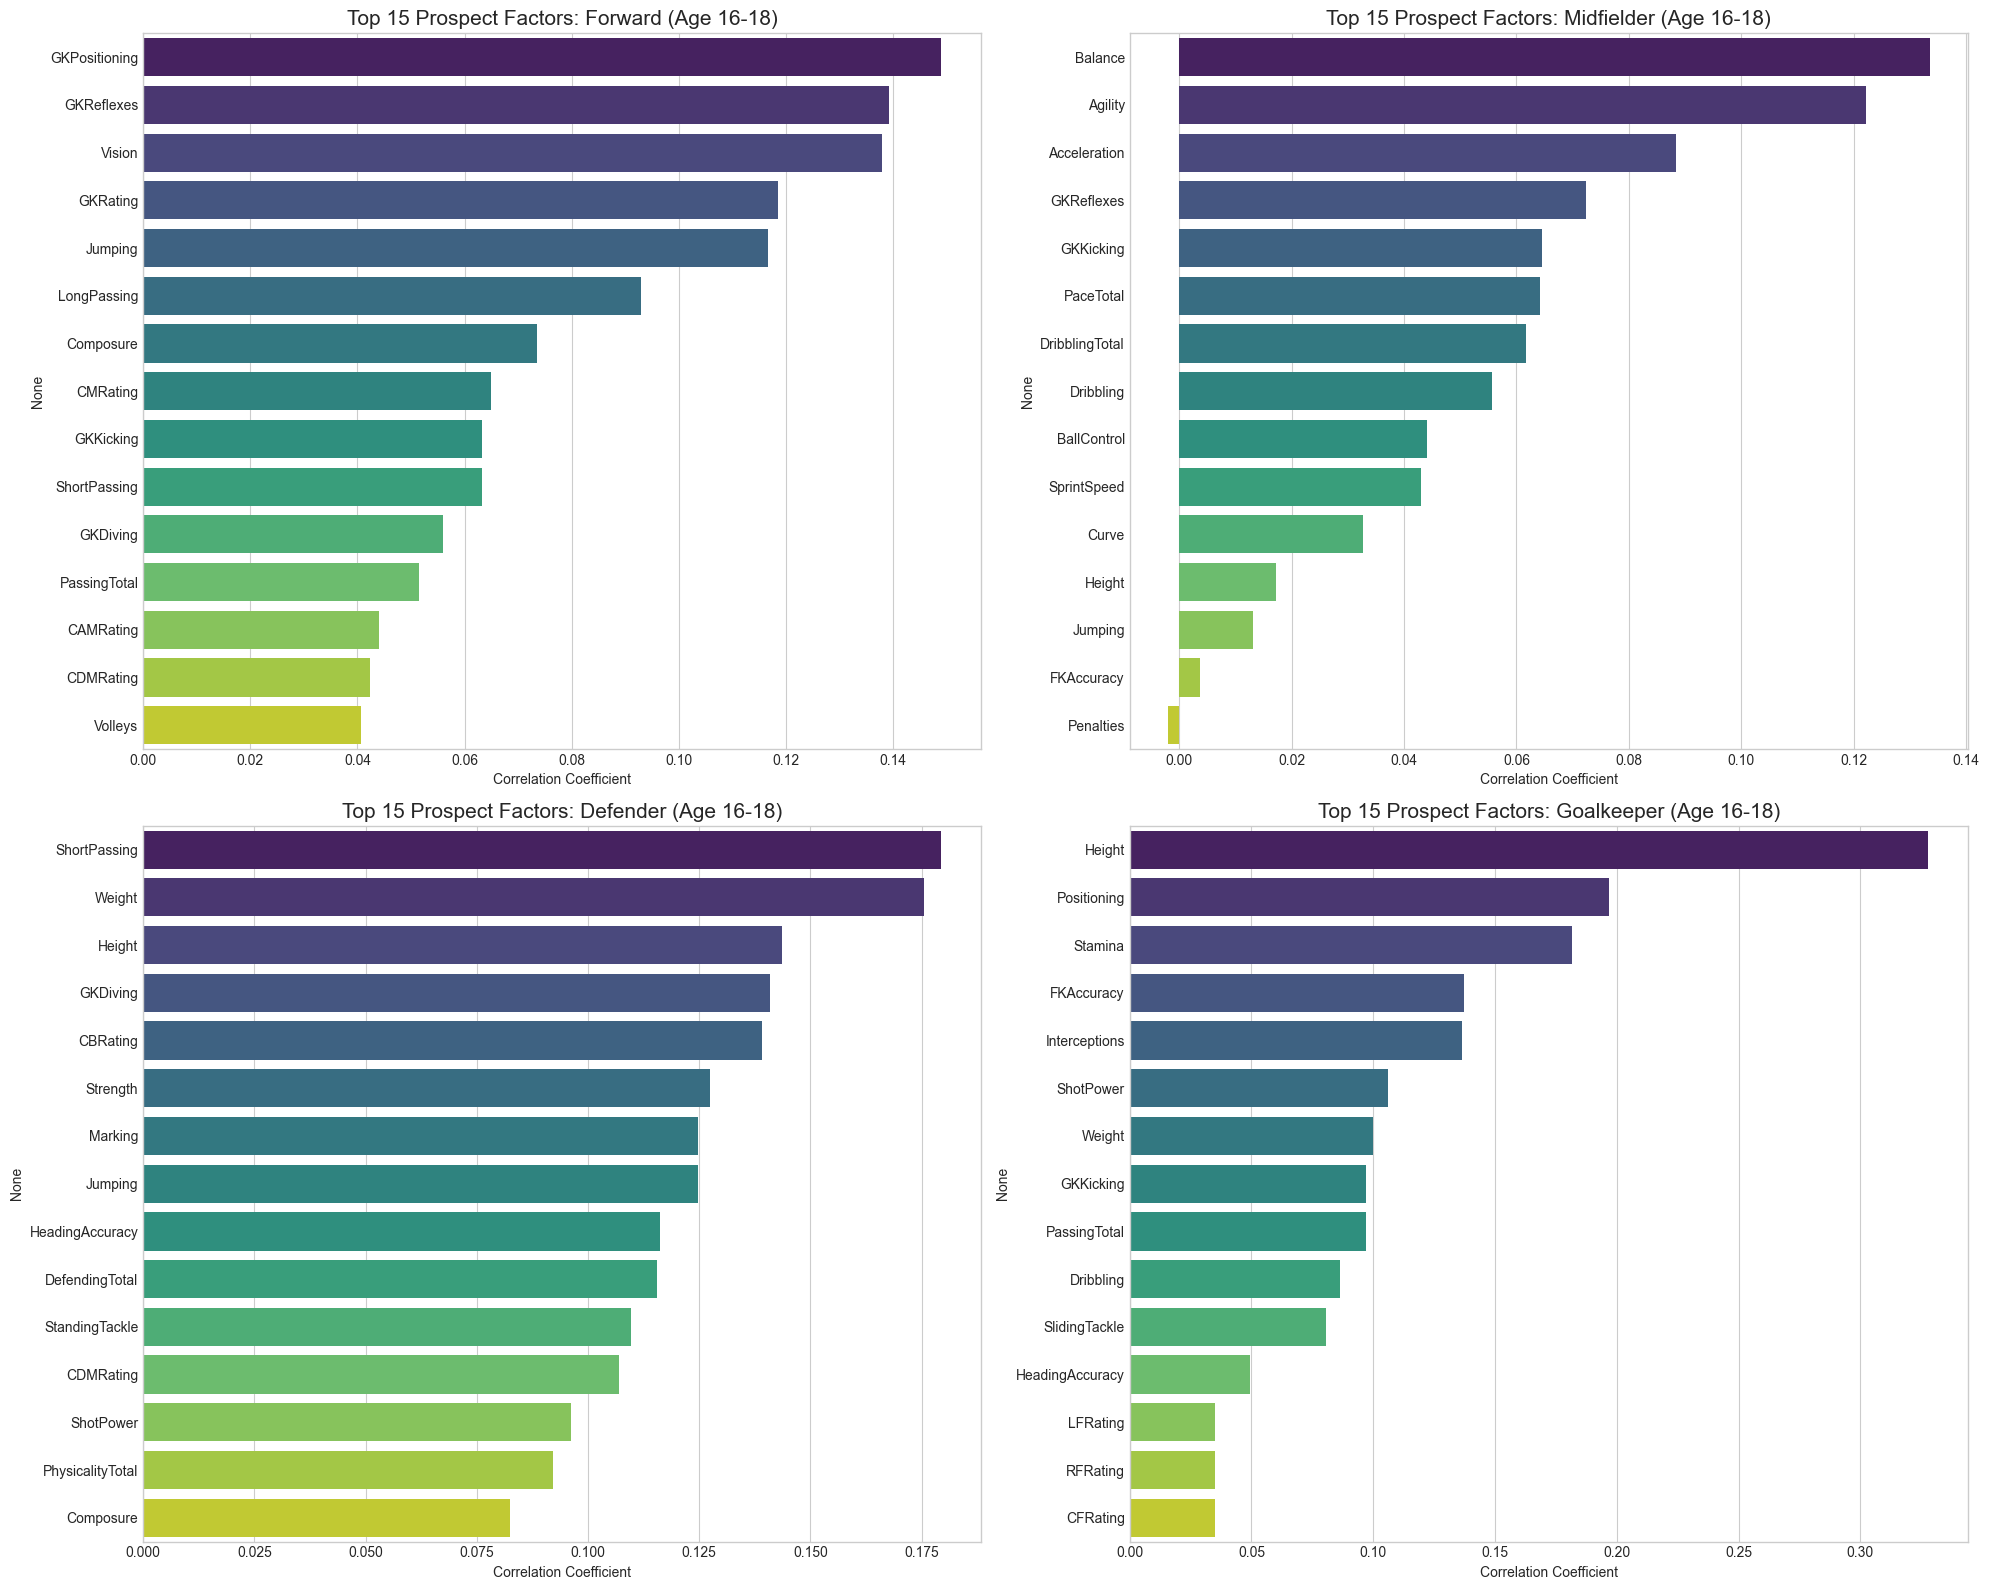

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 포지션 매핑 사전 정의
pos_map = {
    'ST': 'Forward', 'CF': 'Forward', 'RW': 'Forward', 'LW': 'Forward',
    'CAM': 'Midfielder', 'CM': 'Midfielder', 'CDM': 'Midfielder', 'RM': 'Midfielder', 'LM': 'Midfielder',
    'CB': 'Defender', 'RB': 'Defender', 'LB': 'Defender', 'RWB': 'Defender', 'LWB': 'Defender',
    'GK': 'Goalkeeper'
}

# 2. 16-18세 데이터 필터링 및 포지션 그룹 생성
df_target = base_data[base_data['Age'].isin([16, 17, 18])].copy()
df_target['Pos_Group'] = df_target['Position'].map(pos_map)

# 3. 포지션별 시각화 (2x2 Layout)
groups = ['Forward', 'Midfielder', 'Defender', 'Goalkeeper']
plt.figure(figsize=(20, 16))

for i, group in enumerate(groups, 1):
    plt.subplot(2, 2, i)
    
    # 해당 포지션 그룹만 추출
    sub_df = df_target[df_target['Pos_Group'] == group]
    
    # 수치형 데이터 상관계수 계산 (Prospect 기준)
    # 나이와 포지션 평점 점수들을 제외하면 순수 능력치 위주로 볼 수 있습니다.
    numeric_sub = sub_df.select_dtypes(include=['number'])
    corr = numeric_sub.corr()['Prospect'].drop(['Prospect', 'Age'], errors='ignore')
    
    # 상관계수가 높은 상위 15개 지표 추출
    top_corr = corr.sort_values(ascending=False).head(15)
    
    sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
    plt.title(f'Top 15 Prospect Factors: {group} (Age 16-18)', fontsize=15)
    plt.xlabel('Correlation Coefficient')

plt.tight_layout()
plt.show()

#### 공격수 데이터에 GK데이터가 포함되어 빼고 다시 시각화

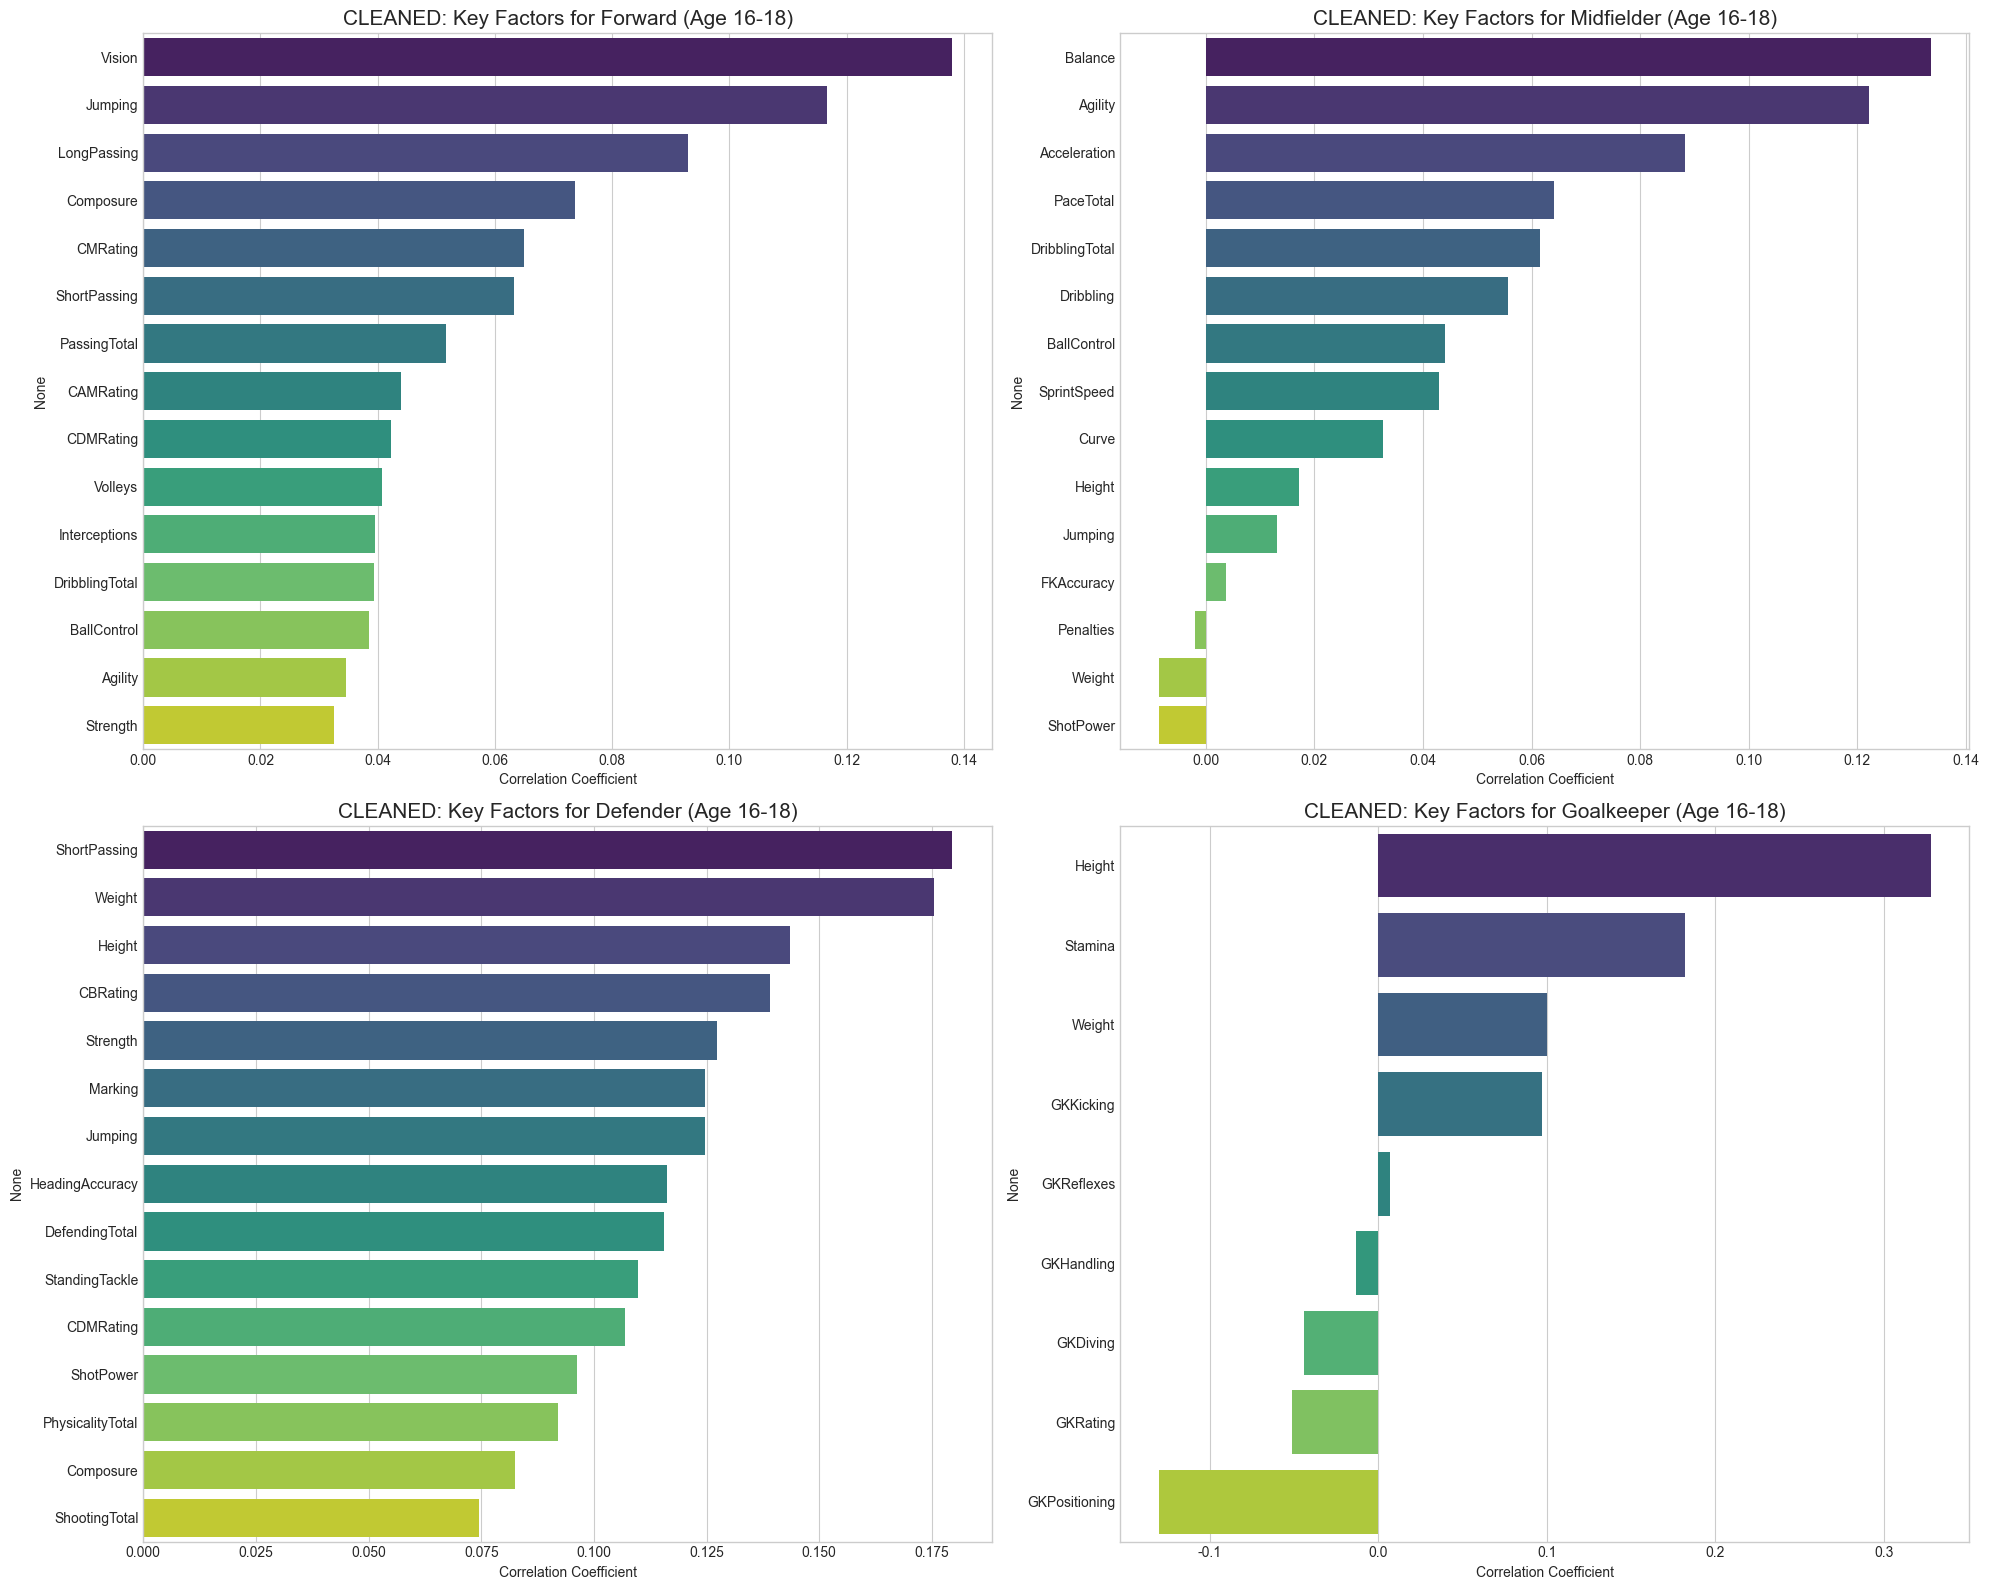

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 16-18세 데이터 및 포지션 그룹 준비
gk_cols = [c for c in base_data.columns if c.startswith('GK')]

plt.figure(figsize=(20, 16))

groups = ['Forward', 'Midfielder', 'Defender', 'Goalkeeper']

for i, group in enumerate(groups, 1):
    plt.subplot(2, 2, i)
    
    # 해당 포지션 그룹 추출
    sub_df = df_target[df_target['Pos_Group'] == group].copy()
    numeric_sub = sub_df.select_dtypes(include=['number'])
    
    # [수정된 필터링 로직]
    if group == 'Goalkeeper':
        # 골키퍼는 GK 지수 + 신체 조건 + Prospect 포함
        analysis_cols = [c for c in numeric_sub.columns if c.startswith('GK') or c in ['Height', 'Weight', 'Stamina', 'Prospect']]
    else:
        # 필드 플레이어는 GK 관련 제거 + Prospect 포함
        analysis_cols = [c for c in numeric_sub.columns if c not in gk_cols and c != 'Age']
        # 만약 analysis_cols에 Prospect가 없다면 추가 (안정장치)
        if 'Prospect' not in analysis_cols:
            analysis_cols.append('Prospect')

    # 상관계수 계산
    # 'Prospect' 컬럼이 포함된 데이터프레임에서 상관계수를 구한 뒤 Prospect 본인은 드롭
    corr = numeric_sub[analysis_cols].corr()['Prospect'].drop('Prospect', errors='ignore')
    top_corr = corr.sort_values(ascending=False).head(15)
    
    sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
    plt.title(f'CLEANED: Key Factors for {group} (Age 16-18)', fontsize=15)
    plt.xlabel('Correlation Coefficient')

plt.tight_layout()
plt.show()

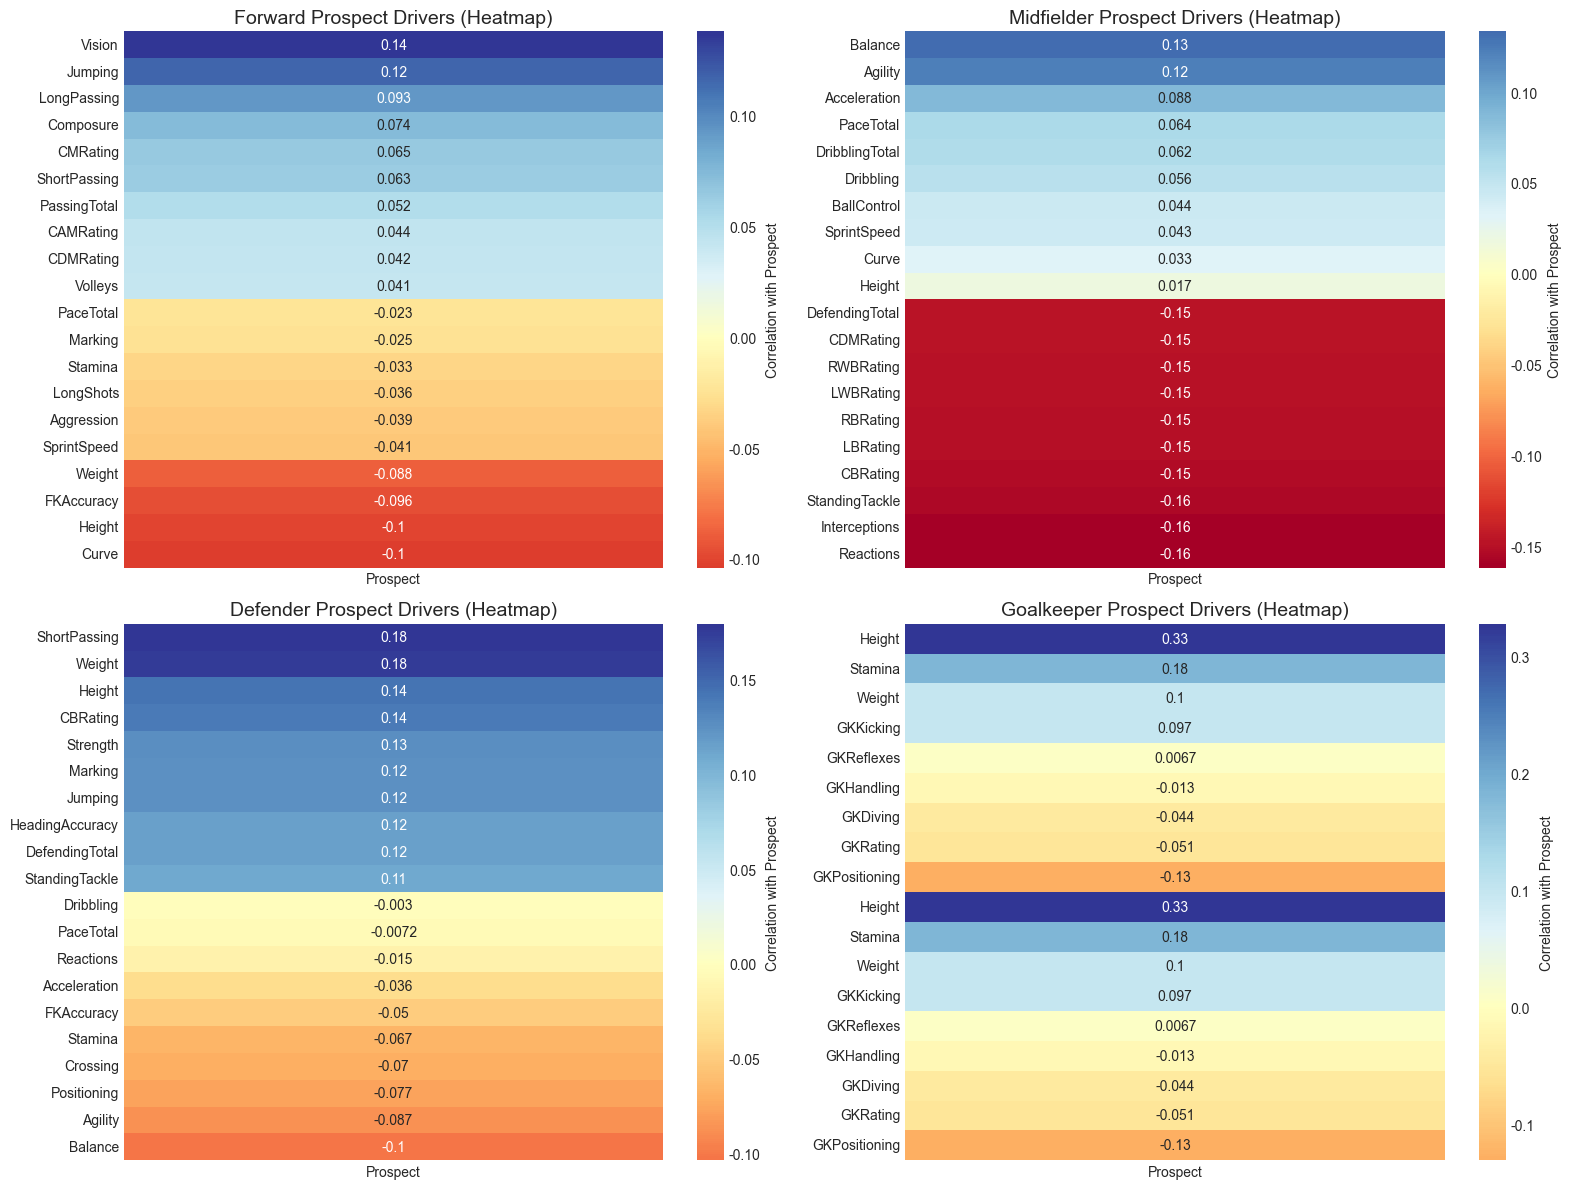

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 시각화 설정
plt.figure(figsize=(16, 12))
groups = ['Forward', 'Midfielder', 'Defender', 'Goalkeeper']

for i, group in enumerate(groups, 1):
    plt.subplot(2, 2, i)
    
    # 해당 포지션 데이터 필터링
    sub_df = df_target[df_target['Pos_Group'] == group].copy()
    numeric_sub = sub_df.select_dtypes(include=['number'])
    
    # 2. 포지션별 맞춤 컬럼 필터링 (노이즈 제거)
    if group == 'Goalkeeper':
        analysis_cols = [c for c in numeric_sub.columns if c.startswith('GK') or c in ['Height', 'Weight', 'Stamina', 'Prospect']]
    else:
        # 필드 플레이어는 GK 지수 제외
        analysis_cols = [c for c in numeric_sub.columns if not c.startswith('GK') and c != 'Age']
        if 'Prospect' not in analysis_cols:
            analysis_cols.append('Prospect')

    # 3. Prospect와의 상관계수 계산 후 정렬
    # 히트맵을 예쁘게 만들기 위해 상위 10개, 하위 10개 지표만 추출
    full_corr = numeric_sub[analysis_cols].corr()[['Prospect']].drop('Prospect', errors='ignore')
    top_bottom_corr = pd.concat([full_corr.sort_values('Prospect', ascending=False).head(10),
                                 full_corr.sort_values('Prospect', ascending=False).tail(10)])

    # 4. 히트맵 그리기
    sns.heatmap(top_bottom_corr, annot=True, cmap='RdYlBu', center=0, cbar_kws={'label': 'Correlation with Prospect'})
    plt.title(f'{group} Prospect Drivers (Heatmap)', fontsize=14)

plt.tight_layout()
plt.show()

### 포지션 그룹,핵심 판별 지표 (Scoring Metrics),판별 전략\
공격수 (FW),"Vision, Jumping, LongPassing, Composure",지능적이고 공중볼이 강한 공격수 찾기\
미드필더 (MF),"Balance, Agility, Acceleration, PaceTotal",기동력과 신체 밸런스가 좋은 중원 자원 찾기\
수비수 (DF),"ShortPassing, Weight, Height, Strength",빌드업이 가능한 거구의 현대적 수비수 찾기\
골키퍼 (GK),"Height, Stamina, Weight",압도적인 신체 조건을 가진 골키퍼 찾기\

공격수의 경우 Vision, Jumping, LongPassing, Composure를 넣을 시 나이 많은 선수가 상위권으로 많이 뽑혀 도메인 지식 기반 컬럼 다시 선정\
['Acceleration', 'Finishing', 'Agility']

In [7]:
import pandas as pd

# 1. 포지션 그룹 매핑 (TRAIN 데이터 대상)
pos_map = {
    'ST': 'Forward', 'CF': 'Forward', 'RW': 'Forward', 'LW': 'Forward',
    'CAM': 'Midfielder', 'CM': 'Midfielder', 'CDM': 'Midfielder', 'RM': 'Midfielder', 'LM': 'Midfielder',
    'CB': 'Defender', 'RB': 'Defender', 'LB': 'Defender', 'RWB': 'Defender', 'LWB': 'Defender',
    'GK': 'Goalkeeper'
}

# TRAIN 데이터만 따로 떼어내서 작업 (데이터 오염 방지)
train_data = base_data[base_data['ID'].str.contains('TRAIN')].copy()
train_data['Pos_Group'] = train_data['Position'].map(pos_map)

# 2. 검증된 유망주 판별 공식 (수정된 공격수 지표 + 나이 페널티 10%)
def get_train_scouting_score(row):
    pos, age = row['Pos_Group'], row['Age']
    if pd.isna(pos): return 0
    
    # [포지션별 핵심 가중치] - TRAIN 검증에서 성능이 가장 좋았던 조합
    if pos == 'Forward':    base_score = (row['Acceleration'] * 0.15) + (row['Finishing'] * 0.15) + (row['Agility'] * 0.10)
    elif pos == 'Midfielder':base_score = (row['Balance'] * 3.5) + (row['Agility'] * 3.0) + \
               (row['ShortPassing'] * 2.5) + (row['Acceleration'] * 1.0)
    elif pos == 'Defender':   base_score = (row['ShortPassing'] * 0.18) + (row['Weight'] * 0.18) + (row['Height'] * 0.14)
    elif pos == 'Goalkeeper': base_score = (row['Height'] * 0.33) + (row['Stamina'] * 0.18) + (row['Weight'] * 0.10)
    else: return 0
        
    # 나이 페널티 (16세 기준 1.0, 1살당 10% 차감)
    age_factor = 1.0 - (age - 16) * 0.10
    return base_score * age_factor

# 3. 점수 계산 및 포지션별 순위 생성
train_data['Scouting_Score'] = train_data.apply(get_train_scouting_score, axis=1)
train_data['Rank'] = train_data.groupby('Pos_Group')['Scouting_Score'].rank(ascending=False)

# 4. 결과 출력: TRAIN 데이터 TOP 10 (정확도 확인용)
print("🔍 Little Sonny 엔진 검증: 학습 데이터(TRAIN) 포지션별 상위 선수")
train_verify_report = train_data[train_data['Rank'] <= 15].sort_values(['Pos_Group', 'Rank'])
display(train_verify_report[['ID', 'Age', 'Pos_Group', 'Scouting_Score', 'Prospect', 'Rank']])

# 5. 간단한 성능 지표 출력
accuracy = (train_verify_report['Prospect'] == 1).mean() * 100
print(f"\n✅ 현재 공식의 TOP 15 유망주 적중률: {accuracy:.1f}%")

🔍 Little Sonny 엔진 검증: 학습 데이터(TRAIN) 포지션별 상위 선수


,ID,Age,Pos_Group,Scouting_Score,Prospect,Rank
2841,TRAIN_2841,17,Defender,41.262946,1.0,1.0
1569,TRAIN_1569,16,Defender,40.807718,1.0,2.0
1732,TRAIN_1732,17,Defender,38.639273,1.0,3.0
1917,TRAIN_1917,17,Defender,38.217685,1.0,4.0
1314,TRAIN_1314,17,Defender,38.007752,1.0,5.0
1614,TRAIN_1614,16,Defender,37.967474,1.0,6.0
498,TRAIN_0498,17,Defender,37.919273,1.0,7.0
1856,TRAIN_1856,17,Defender,37.643425,1.0,8.0
157,TRAIN_0157,16,Defender,37.528920,1.0,9.0
1787,TRAIN_1787,17,Defender,37.293836,1.0,10.0



✅ 현재 공식의 TOP 15 유망주 적중률: 96.7%


In [47]:
# 1. 포지션 그룹 생성 및 데이터 분리
pos_map = {
    'ST': 'Forward', 'CF': 'Forward', 'RW': 'Forward', 'LW': 'Forward',
    'CAM': 'Midfielder', 'CM': 'Midfielder', 'CDM': 'Midfielder', 'RM': 'Midfielder', 'LM': 'Midfielder',
    'CB': 'Defender', 'RB': 'Defender', 'LB': 'Defender', 'RWB': 'Defender', 'LWB': 'Defender',
    'GK': 'Goalkeeper'
}

# base_data에서 train 부분만 안전하게 복사
train_data = base_data[base_data['is_train'] == True].copy()

# [중요] Pos_Group 컬럼 먼저 생성
train_data['Pos_Group'] = train_data['Position'].map(pos_map)

# 2. Scouting_Score 계산 (함수 정의는 위에 있다고 가정)
train_data['Scouting_Score'] = train_data.apply(get_train_scouting_score, axis=1)

# 3. 모델 학습에 사용할 특징(Feature) 정의 
# 주의: 'Pos_Group'은 문자열이라 모델(X)에 바로 넣으면 에러가 날 수 있습니다. 
# 수치형 데이터인 'Scouting_Score'만 포함시키세요!
features = [
    'Age', 'Scouting_Score',                     
    'Stamina', 'Reactions', 'Crossing', 'Jumping', 
    'Balance', 'SlidingTackle', 'GKKicking',     
    'ShootingTotal', 'Positioning', 'Composure',
    'Finishing', 'PassingTotal', 'BallControl',   
    'PhysicalityTotal', 'Strength', 'Acceleration',
    'Agility', 'Height'  
]

# 4. 최종 데이터셋 구성 및 스케일링
X = train_data[features]
y = train_data['Prospect']

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print("✅ 모든 데이터 준비 완료! 이제 모델 학습을 진행합니다.")

✅ 모든 데이터 준비 완료! 이제 모델 학습을 진행합니다.


In [49]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_predict

# 1. 8개 모델 리스트 재정의 (동일)
models = [
    ('RF', RandomForestClassifier(random_state=42)),
    ('XGB', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('LGBM', LGBMClassifier(random_state=42, verbose=-1)), # 로그 지우기
    ('GBM', GradientBoostingClassifier(random_state=42)),
    ('ET', ExtraTreesClassifier(random_state=42)),
    ('LR', LogisticRegression(random_state=42)),
    ('ADA', AdaBoostClassifier(random_state=42)),
    ('SVM', SVC(probability=True, random_state=42))
]

print("📊 [Little Sonny] 모델별 교차 검증 F1-Score (Threshold=0.5 기준)")
f1_results = []

for name, model in models:
    # f1_score 기준 교차 검증
    cv_f1_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')
    f1_results.append((name, cv_f1_scores.mean(), model))
    print(f"{name:5}: F1 = {cv_f1_scores.mean():.4f}")

# 2. 가장 F1이 좋은 모델 선정
best_f1_info = max(f1_results, key=lambda x: x[1])
best_model_name = best_f1_info[0]
best_model_obj = best_f1_info[2]

print(f"\n🏆 F1 기준 최적의 모델: {best_model_name}")

# 3. 최적 모델을 사용하여 Threshold 튜닝
print(f"⚙️ {best_model_name} 모델의 최적 Threshold 찾는 중...")

# 교차 검증 기반의 예측 확률 계산
y_probas = cross_val_predict(best_model_obj, X_scaled, y, cv=5, method='predict_proba')[:, 1]

best_threshold = 0.5
max_f1 = 0

for th in np.arange(0.1, 0.9, 0.01):
    preds = (y_probas >= th).astype(int)
    score = f1_score(y, preds)
    if score > max_f1:
        max_f1 = score
        best_threshold = th

print(f"✅ 최적 Threshold: {best_threshold:.2f}")
print(f"🚀 최적화 후 예상 F1: {max_f1:.4f}")

# 4. 최종 모델 학습 (전체 데이터) 및 예측
best_model_obj.fit(X_scaled, y)
test_probas = best_model_obj.predict_proba(X_test_scaled)[:, 1]
final_preds = (test_probas >= best_threshold).astype(int)

📊 [Little Sonny] 모델별 교차 검증 F1-Score (Threshold=0.5 기준)
RF   : F1 = 0.6847
XGB  : F1 = 0.6684
LGBM : F1 = 0.6648
GBM  : F1 = 0.6734
ET   : F1 = 0.6665
LR   : F1 = 0.6701
ADA  : F1 = 0.6974
SVM  : F1 = 0.6645

🏆 F1 기준 최적의 모델: ADA
⚙️ ADA 모델의 최적 Threshold 찾는 중...
✅ 최적 Threshold: 0.47
🚀 최적화 후 예상 F1: 0.7123


In [55]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# 1. 데이터 불균형 해결 (SMOTE)
# 유망주(1) 데이터를 인공적으로 늘려 모델이 더 잘 학습하게 합니다.
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

# 2. 검증된 에이스 모델들 정의
# ADA는 성능이 가장 좋았으므로 가중치를 높게 줍니다.
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=200, learning_rate=0.05, random_state=42
)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
gbm_model = GradientBoostingClassifier(random_state=42)

# 3. 가중치 보팅 앙상블 (ADA:RF:GBM = 3:1:1)
ensemble_model = VotingClassifier(
    estimators=[('ADA', ada_model), ('RF', rf_model), ('GBM', gbm_model)],
    voting='soft',
    weights=[3, 1, 1]
)

# 4. 최적 Threshold 탐색 및 성능 확인
print("🚀 앙상블 모델 교차 검증 및 최적 Threshold 탐색 중...")
y_probas = cross_val_predict(ensemble_model, X_res, y_res, cv=5, method='predict_proba')[:, 1]

best_th, max_f1 = 0.5, 0
for th in np.arange(0.1, 0.7, 0.01):
    score = f1_score(y_res, (y_probas >= th).astype(int))
    if score > max_f1:
        max_f1, best_th = score, th

print(f"\n✨ 최종 앙상블 결과 ✨")
print(f"✅ 최적 Threshold: {best_th:.2f}")
print(f"🚀 예상 최고 F1-Score: {max_f1:.4f}")

# 5. 최종 학습 및 제출 파일 생성
ensemble_model.fit(X_res, y_res)
final_probs = ensemble_model.predict_proba(X_test_scaled)[:, 1]
submission['Prospect'] = (final_probs >= best_th).astype(int)
submission.to_csv('submission_ensemble_final.csv', index=False)

🚀 앙상블 모델 교차 검증 및 최적 Threshold 탐색 중...

✨ 최종 앙상블 결과 ✨
✅ 최적 Threshold: 0.40
🚀 예상 최고 F1-Score: 0.8290


In [56]:
# 1. 테스트 데이터에 대한 예측 확률 추출
final_probs = ensemble_model.predict_proba(X_test_scaled)[:, 1]

# 2. 최적 임계값(0.40) 적용하여 0 또는 1로 변환

final_preds = (final_probs >= 0.40).astype(int)

# 3. 제출용 데이터프레임 생성
submission['Prospect'] = final_preds

# 4. CSV 파일로 저장

file_name = 'submission_ensemble_best.csv'
submission.to_csv(file_name, index=False)

print(f"✅ 파일 생성 완료: {file_name}")
print(f"📊 예측된 유망주(1) 개수: {sum(final_preds)}개")
print("🚀 이제 이 파일을 리더보드에 제출해 보세요!")

✅ 파일 생성 완료: submission_ensemble_best.csv
📊 예측된 유망주(1) 개수: 784개
🚀 이제 이 파일을 리더보드에 제출해 보세요!


In [ ]:
# from autogluon.tabular import TabularPredictor
# import shutil
# import os

# # 1. 피처 리스트 (중복 가능성 제거)
# raw_features = [
#     'Age', 'Scouting_Score', 'Pos_Group', 'Acceleration', 'Finishing', 
#     'Agility', 'ShortPassing', 'Balance', 'Weight', 'Height', 'Stamina', 
#     'Dribbling', 'BallControl', 'Volleys', 'GKKicking', 'Strength'
# ]

# # 중복된 이름이 있다면 하나만 남기고 정리
# unique_features = list(dict.fromkeys(raw_features)) 

# # 2. 데이터 생성 (여기서 중복 컬럼 에러를 방지합니다)
# # Prospect가 features에 포함되어 있을 경우를 대비해 처리
# target = 'Prospect'
# final_cols = [c for c in unique_features if c != target] + [target]
# train_df = train_data[final_cols].copy()

# # 3. 기존 폴더 정리
# save_path = 'ag_sonny_final_v5'
# if os.path.exists(save_path):
#     shutil.rmtree(save_path, ignore_errors=True)

# # 4. 학습 시작
# print("🚀 중복 컬럼을 제거하고 학습을 다시 시작합니다...")

# predictor = TabularPredictor(
#     label=target, 
#     path=save_path, 
#     eval_metric='f1'
# ).fit(
#     train_data=train_df,
#     presets='best_quality', 
#     time_limit=900,         
#     dynamic_stacking=False, 
#     num_stack_levels=1,     
#     ag_args_fit={'num_cpus': 9} # 사용자님의 설정 유지
# )

# # 결과 확인
# leaderboard = predictor.leaderboard(train_df, silent=True)
# display(leaderboard)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          14
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       15.38 GB / 31.53 GB (48.8%)
Disk Space Avail:   110.54 GB / 212.20 GB (52.1%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1


🚀 중복 컬럼을 제거하고 학습을 다시 시작합니다...


Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "c:\Users\subin\github\Little-Sonny\ag_sonny_final_v5"
Train Data Rows:    3019
Train Data Columns: 16
Label Column:       Prospect
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [np.float64(0.0), np.float64(1.0)]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    15719.34 MB
	Train Data (Original)  Memory Usage: 0.54 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.998626,0.684211,f1,1.233000,1.040128,5.117622,0.029005,0.002929,0.377546,2,True,6
1,ExtraTreesGini_BAG_L1,0.998168,0.675931,f1,0.387714,0.407276,1.537712,0.387714,0.407276,1.537712,1,True,3
2,ExtraTreesEntr_BAG_L1,0.997712,0.670594,f1,0.536922,0.354184,1.781345,0.536922,0.354184,1.781345,1,True,4
3,RandomForestGini_BAG_L1,0.997255,0.675134,f1,0.279359,0.275738,1.421019,0.279359,0.275738,1.421019,1,True,1
4,RandomForestEntr_BAG_L1,0.995434,0.669574,f1,0.321551,0.351867,1.520105,0.321551,0.351867,1.520105,1,True,2
5,ExtraTrees_r42_BAG_L1,0.994526,0.665046,f1,0.388231,0.241688,1.842036,0.388231,0.241688,1.842036,1,True,5
6,RandomForestGini_BAG_L2,0.940818,0.677404,f1,1.822954,1.600872,7.823388,0.297408,0.211806,1.563207,2,True,7
7,WeightedEnsemble_L3,0.940357,0.689018,f1,2.474674,2.141653,11.296186,0.005353,0.003301,0.362545,3,True,11
8,RandomForestEntr_BAG_L2,0.935555,0.681329,f1,1.783489,1.610726,7.636899,0.257943,0.221659,1.376717,2,True,8
9,ExtraTreesEntr_BAG_L2,0.924601,0.672879,f1,1.809997,1.827854,7.986956,0.284451,0.438788,1.726775,2,True,10


In [ ]:
# # 1. TEST 데이터 정의 (NameError 방지)
# test_data = base_data[base_data['ID'].str.contains('TEST')].copy()
# test_data['Pos_Group'] = test_data['Position'].map(pos_map)
# test_data['Scouting_Score'] = test_data.apply(get_scouting_score, axis=1)

# # final_preds = predictor.predict(test_data[features]) 